# Post-Processing Notebook

In [184]:
#necessary imports
import post_utils as pu
import numpy as np
import pandas as pd
import diameter_utils as du
import joblib
import allometric_equations as ae

In [38]:
#setting the standard root directory for the project
root_dir = 'data/tiles/processed/'

## Loading in the data and setting the necessary visual information

In [39]:
cmap, norm, legend_info = pu.set_visuals()

In [40]:
species_map_path = 'species_map_epoch_0.5.pkl'
distance_map_path = 'distance_map_epoch_0.5.pkl'
probability_map_path = 'probability_map_epoch_0.5.pkl'
original_image_path = 'original_image_epoch_0.5.pkl'
species_ground_truth_path = 'species_map_true_epoch_0.5.pkl'
distance_ground_truth_path = 'distance_map_true_epoch_0.5.pkl'
maps_root_dir = 'pkl_files/'

In [41]:
species_pred = pu.load_map(maps_root_dir + species_map_path)

In [42]:
distance_pred = pu.load_map(maps_root_dir + distance_map_path)

In [43]:
probability_map = pu.load_map(maps_root_dir + probability_map_path)

In [44]:
original_images = pu.load_map(maps_root_dir + original_image_path)

In [45]:
species_true = pu.load_map(maps_root_dir + species_ground_truth_path)

In [46]:
distances_true = pu.load_map(maps_root_dir + distance_ground_truth_path)

## Probability 

### visualize the maximum probability in one selected image

Overall Maximum Probability: 80.48%
Location of Overall Maximum Probability: (3540, 2799)


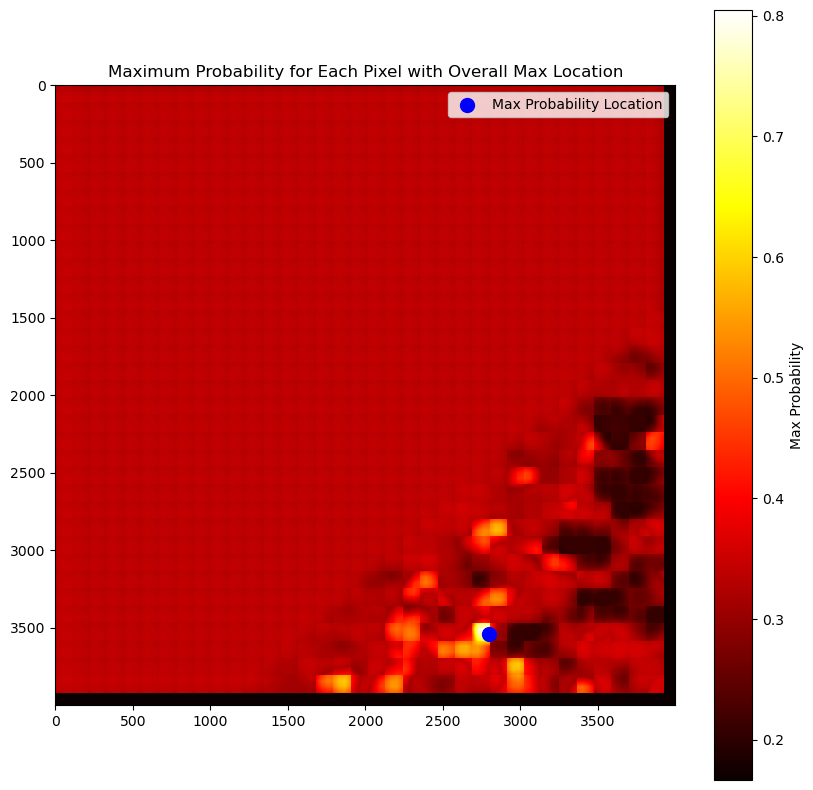

In [47]:
selected_prob_image = probability_map[0]
pu.select_and_visualize_prob(selected_prob_image)

In [48]:
#for all the images, finding the percentage that are low probability pixels 
pu.print_low_prob(probability_map)

Percentage of Pixels with Probability < 0.2: 3.97%
Percentage of Pixels with Probability < 0.2: 4.25%
Percentage of Pixels with Probability < 0.2: 3.98%
Percentage of Pixels with Probability < 0.2: 4.03%
Percentage of Pixels with Probability < 0.2: 3.97%
Percentage of Pixels with Probability < 0.2: 4.09%
Percentage of Pixels with Probability < 0.2: 5.85%
Percentage of Pixels with Probability < 0.2: 4.95%
Percentage of Pixels with Probability < 0.2: 5.83%
Percentage of Pixels with Probability < 0.2: 4.33%
Percentage of Pixels with Probability < 0.2: 4.33%
Percentage of Pixels with Probability < 0.2: 4.98%


In [49]:
#modify the species maps to remove the low probability pixels
species_predictions = pu.apply_modification(probability_map, species_pred)

In [50]:
#delete old species map for memory management
del species_pred

In [51]:
#make the new species map into a numpy array
species_predictions = np.array(species_predictions)

In [52]:
#take the argmax of the species predictions to get the final species map
species_predictions = np.argmax(species_predictions, axis=1)

In [53]:
#make the distance map a numpy array and delete the old distance map for memory management
distance_predictions = np.array(distance_pred)
distance_predictions = np.squeeze(distance_predictions, axis=1)
del distance_pred

In [54]:
#make ground truth species map a numpy array and delete the old species map for memory management
targets = np.array(species_true)
targets = np.squeeze(targets, axis=1)
del species_true

In [55]:
#make the ground truth distance map a numpy array and delete the old distance map for memory management
distance_targets = np.array(distances_true)
del distances_true

In [56]:
print(f"targets shape: {targets.shape}")
print(f"distance_maps shape: {distance_targets.shape}")
print(f"species_maps_pred shape: {species_predictions.shape}")
print(f"distance_maps_pred shape: {distance_predictions.shape}")

targets shape: (12, 4000, 4000)
distance_maps shape: (12, 4000, 4000)
species_maps_pred shape: (12, 4000, 4000)
distance_maps_pred shape: (12, 4000, 4000)


## Visualize one from Each Category 

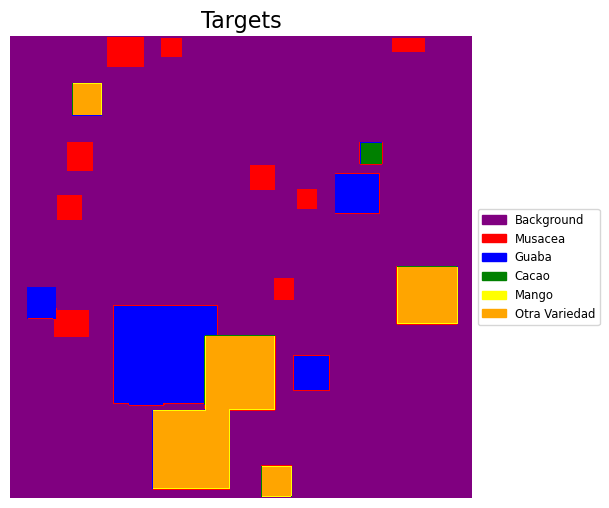

In [65]:
pu.show_image_with_legend(image=targets[1], title='Targets', cmap=cmap, norm=norm, legend_info=legend_info)

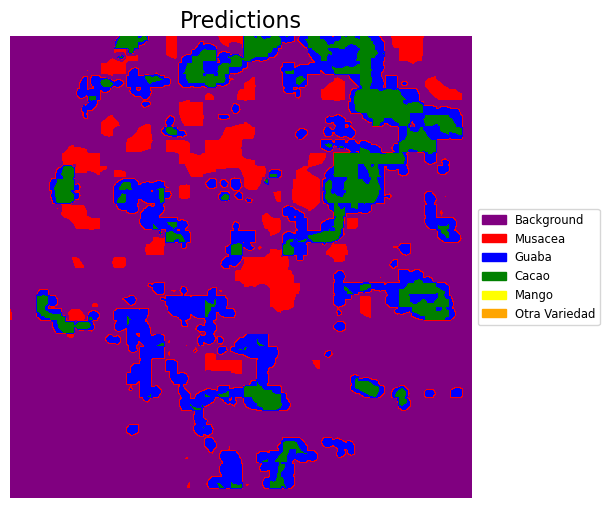

In [66]:
pu.show_image_with_legend(image=species_predictions[1], title='Predictions', cmap=cmap, norm=norm, legend_info=legend_info)

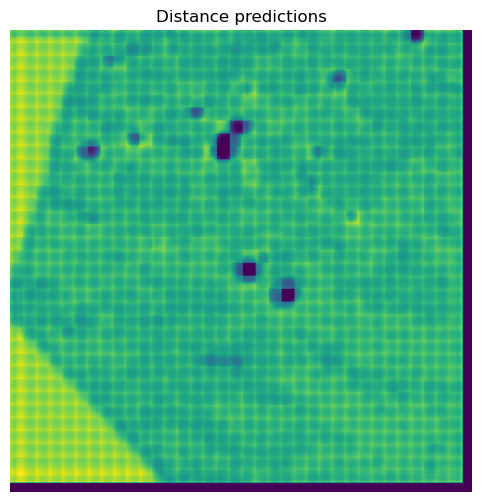

In [70]:
pu.visualize_step(distance_predictions[1], "Distance predictions", cmap='viridis')

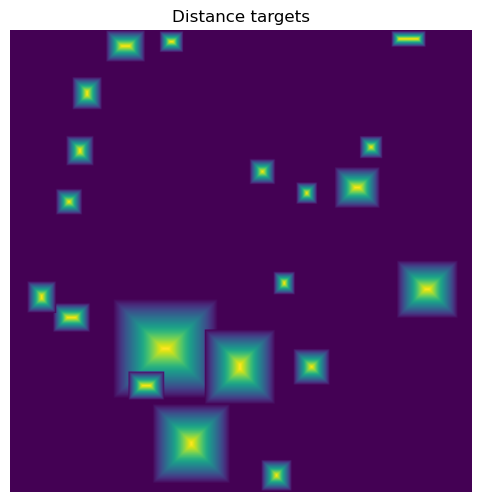

In [69]:
pu.visualize_step(distance_targets[1], "Distance targets", cmap='viridis')

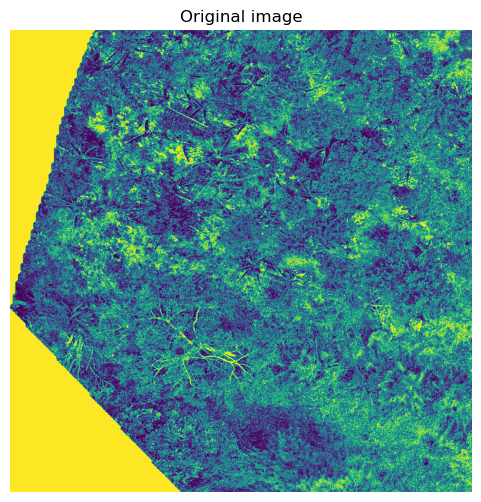

In [74]:
pu.visualize_step(original_images[1][2], "Original image", cmap='viridis')

### Calculate F1 scores at this point 

In [76]:
pu.calculate_average_f1(targets, species_predictions)

0.9570562622879796
0.6891309501659271
0.884422580766096
0.800390665048135
0.7594322599434034
0.8440147616986542
0.7994677477142923
0.4755081699030945
0.2546094567624127
0.6164036193428466
0.873049264198968
0.42190405884566357
Average F1 Score: 0.6979491497231227


______

## Bringing in DeepForest Bounding Boxes

In [90]:
deepforest_results = pd.read_csv('iou_results_deepforest.csv')
deepforest_results_grouped = deepforest_results.groupby('image_path')

In [228]:
binary_deepforest = pu.create_binary_deepforest(deepforest_results_grouped, root_dir, show = False)

### Combining DeepForest Results with Species Results

In [96]:
results, results_normalized = pu.process_images(deepforest_results_grouped, species_predictions)

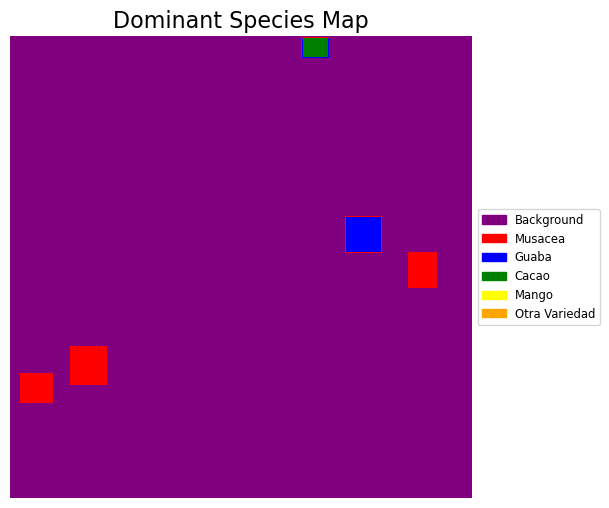

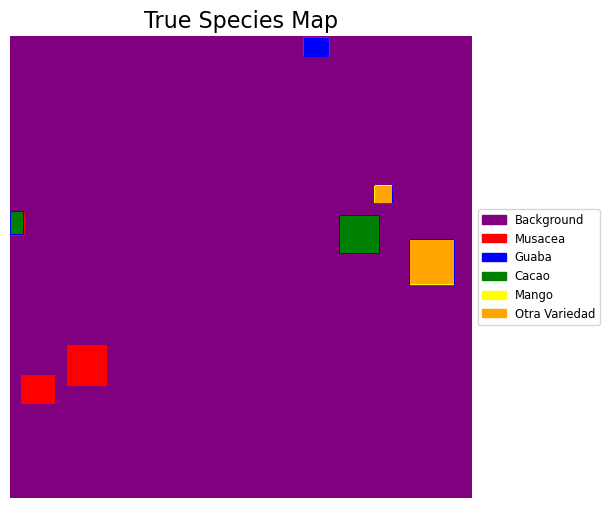

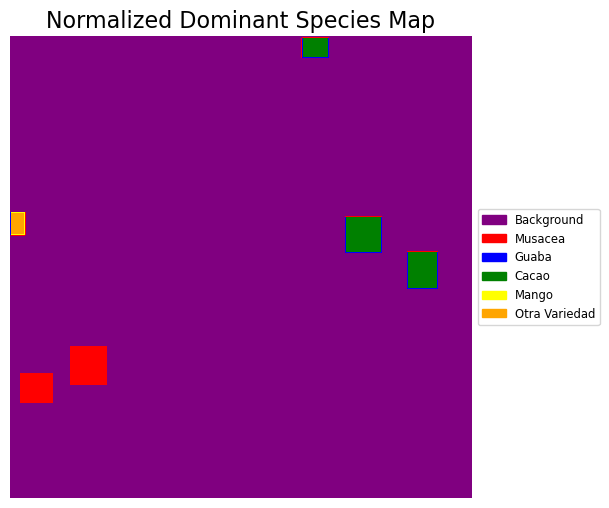

In [102]:
pu.show_image_with_legend(results[6], title='Dominant Species Map', cmap=cmap, norm=norm, legend_info=legend_info)
pu.show_image_with_legend(targets[6], title='True Species Map', cmap=cmap, norm=norm, legend_info=legend_info)
pu.show_image_with_legend(results_normalized[6], title='Normalized Dominant Species Map', cmap=cmap, norm=norm, legend_info=legend_info)

In [103]:
#calculate new f1 scores 
pu.calculate_average_f1(targets, results_normalized)

0.9830986195892736
0.809664346763952
0.9703225283960244
0.9162287383239447
0.998540550380206
0.91954935459492
0.9745576085465074
0.8725207873067378
0.688149709221709
0.8692638985090345
0.9477360943895772
0.8239457917586795
Average F1 Score: 0.8977981689817139


### Put these results in df form as well 

In [186]:
#test dataframe
df = pd.read_csv('test_df_proper.csv')

In [187]:
df = pu.change_column_names(df)

In [188]:
selected_columns = ['true_box_xmin', 'true_box_xmax', 'true_box_ymin', 'true_box_ymax', 'image_path', 'name', 'AGB', 'carbon', 'diameter']
df_original_selected = df[selected_columns]

In [189]:
merged_df = pd.merge(df_original_selected, deepforest_results, on=['true_box_xmin', 'true_box_ymin', 'true_box_xmax', 'true_box_ymax', 'image_path'])
grouped_merged = merged_df.groupby('image_path')

In [190]:
processed_df = pu.species_and_deepforest_df(species_predictions, grouped_merged)

In [191]:
processed_df = pu.change_column_names_back(processed_df)

______

## Calculate Carbon Sequestration Potential

In [192]:
#prepare data using diameter_model specifications 
df_bbox = du.add_bbox_columns(processed_df)

In [193]:
df_prepared = du.prepare_data(df_bbox, 'diameter')

In [194]:
X, y = du.split_data(df_prepared, scaler = True)

In [195]:
#load in the diameter model
xg_model = joblib.load('models/xgboost_model.pkl')

In [196]:
y_pred = xg_model.predict(X)

In [197]:
#check the mse on real world data
du.mse_and_rmse(y, y_pred)

Mean Squared Error: 8.710695512355507
Root Mean Squared Error: 2.9513887430081973


(8.710695512355507, 2.9513887430081973)

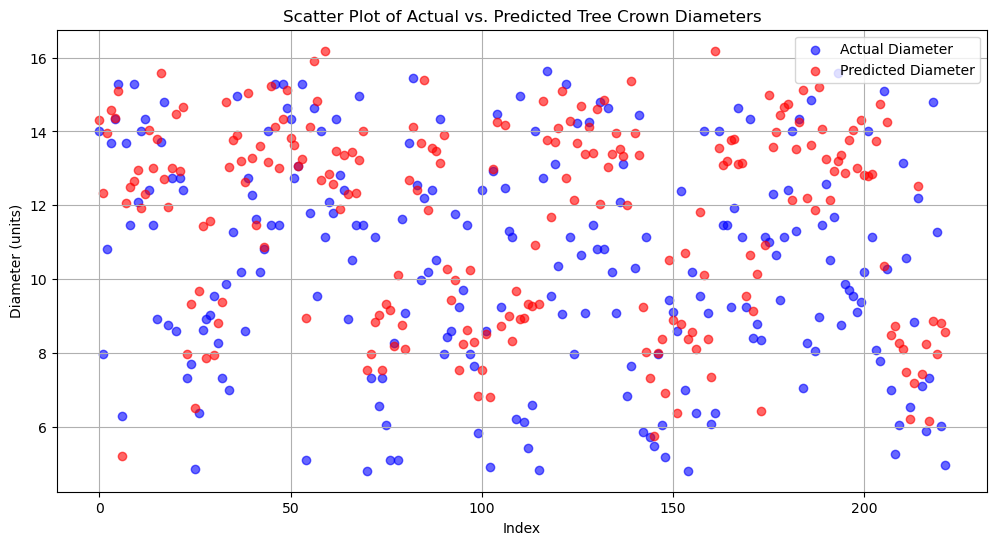

In [198]:
#look at the plot of predicted diameters 
du.plot_results(y, y_pred)

In [199]:
du.compare(y, y_pred)

    Actual Diameter  Predicted Diameter  Difference (Absolute)
0         14.005602           14.308861               0.303259
1          7.957729           12.331306               4.373577
2         10.822511           13.958765               3.136254
3         13.687293           14.585109               0.897816
4         14.323911           14.373336               0.049424
5         15.278839           15.087626               0.191213
6          6.286102            5.208046               1.078056
7         13.687293           12.060033               1.627260
8         11.459129           12.483640               1.024511
9         15.278839           12.651896               2.626943
10        12.095747           12.944078               0.848331
11        14.005602           11.938140               2.067462
12        14.323911           12.311543               2.012369
13        12.414057           14.026447               1.612391
14        11.459129           13.019142               1

### Diameters have been calcualted; now we can use these to calculate AGB

In [200]:
#prepare the processed_df like we did the model 
processed_df = du.prepare_data(processed_df, 'diameter', one_hot_encode=False)
#add the predicted diameters to the processed_df
processed_df['predicted_diameter'] = y_pred

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_19377/3806847740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['predicted_diameter'] = y_pred


In [201]:
#calculate AGB based on the predicted diameters
processed_df['predicted_AGB'] = processed_df.apply(lambda row: ae.calculate_AGB(row['predicted_diameter'], row['predicted_species']), axis=1)

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_19377/3115881145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['predicted_AGB'] = processed_df.apply(lambda row: ae.calculate_AGB(row['predicted_diameter'], row['predicted_species']), axis=1)


In [203]:
#add a column for the difference 
processed_df['AGB_difference'] = abs(processed_df['AGB'] - processed_df['predicted_AGB'])

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_19377/2159281722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['AGB_difference'] = abs(processed_df['AGB'] - processed_df['predicted_AGB'])


### Comparison Metrics

In [206]:
#I will be comparing both the dataframes with species that don't match and with species that do

processed_df_species = processed_df[processed_df['predicted_species'] == processed_df['name']]


#### MSE and RMSE

In [207]:
#first let's look at the mse 
du.mse_and_rmse(processed_df['AGB'], processed_df['predicted_AGB'])

Mean Squared Error: 268.07599687733966
Root Mean Squared Error: 16.373026503287036


(268.07599687733966, 16.373026503287036)

In [208]:
du.mse_and_rmse(processed_df_species['AGB'], processed_df_species['predicted_AGB'])

Mean Squared Error: 26.73540404509871
Root Mean Squared Error: 5.170628979640553


(26.73540404509871, 5.170628979640553)

#### Averages

In [213]:
pu.calculate_AGB_averages(processed_df, processed_df_species)

Including all species
Real AGB Average: 12.449359510054054
Predicted AGB Average: 10.377428790508636
AGB Difference Average: 8.540888912176767
 
Excluding species that don't match their predicted species
Real AGB Average: 6.747350007053334
Predicted AGB Average: 9.065188955558906
AGB Difference Average: 3.3860041156419993


In [220]:
pu.averages_by_image(processed_df, processed_df_species)

Including all species
img_path
Carlos Vera Arteaga RGB_0_0_0_4000_4000.png              1.510353
Carlos Vera Arteaga RGB_2_0_7600_4000_11600.png          7.693862
Carlos Vera Arteaga RGB_5_3800_3800_7800_7800.png        4.977955
Carlos Vera Arteaga RGB_9_7600_3800_11600_7800.png       5.599578
Carlos Vera Guevara RGB_14_8425_7600_12425_11600.png    17.044636
Carlos Vera Guevara RGB_8_7600_0_11600_4000.png         10.176264
Leonor Aspiazu RGB_17_13134_3800_17134_7800.png          4.024576
Leonor Aspiazu RGB_8_7600_0_11600_4000.png              20.604863
Manuel Macias RGB_3_3800_0_7800_4000.png                20.059644
Nestor Macias RGB_1_0_3800_4000_7800.png                 8.504514
Nestor Macias RGB_3_0_9024_4000_13024.png               10.237989
Nestor Macias RGB_7_3800_9024_7800_13024.png             9.447701
Name: AGB_difference, dtype: float64
 
Excluding species that don't match their predicted species
img_path
Carlos Vera Arteaga RGB_0_0_0_4000_4000.png           1.510353
Carlos 

#### Sums

In [224]:
pu.sum_tables(processed_df, processed_df_species)

Including all species
                                                           AGB  predicted_AGB
img_path                                                                     
Carlos Vera Arteaga RGB_0_0_0_4000_4000.png          46.751312      53.933484
Carlos Vera Arteaga RGB_2_0_7600_4000_11600.png     263.988120     323.460997
Carlos Vera Arteaga RGB_5_3800_3800_7800_7800.png   141.832604     234.154784
Carlos Vera Arteaga RGB_9_7600_3800_11600_7800.png  210.166286     293.505871
Carlos Vera Guevara RGB_14_8425_7600_12425_1160...   70.069266      35.979994
Carlos Vera Guevara RGB_8_7600_0_11600_4000.png     371.045416     269.583732
Leonor Aspiazu RGB_17_13134_3800_17134_7800.png      36.394974      24.428711
Leonor Aspiazu RGB_8_7600_0_11600_4000.png           83.681966      25.926854
Manuel Macias RGB_3_3800_0_7800_4000.png            190.897803      72.989778
Nestor Macias RGB_1_0_3800_4000_7800.png            541.248799     484.603996
Nestor Macias RGB_3_0_9024_4000_13024.png 

#### Carbon

In [226]:
pu.carbon_tables(processed_df, processed_df_species)

Including all species
                                                           AGB  predicted_AGB
img_path                                                                     
Carlos Vera Arteaga RGB_0_0_0_4000_4000.png          23.375656      26.966742
Carlos Vera Arteaga RGB_2_0_7600_4000_11600.png     131.994060     161.730499
Carlos Vera Arteaga RGB_5_3800_3800_7800_7800.png    70.916302     117.077392
Carlos Vera Arteaga RGB_9_7600_3800_11600_7800.png  105.083143     146.752936
Carlos Vera Guevara RGB_14_8425_7600_12425_1160...   35.034633      17.989997
Carlos Vera Guevara RGB_8_7600_0_11600_4000.png     185.522708     134.791866
Leonor Aspiazu RGB_17_13134_3800_17134_7800.png      18.197487      12.214355
Leonor Aspiazu RGB_8_7600_0_11600_4000.png           41.840983      12.963427
Manuel Macias RGB_3_3800_0_7800_4000.png             95.448902      36.494889
Nestor Macias RGB_1_0_3800_4000_7800.png            270.624399     242.301998
Nestor Macias RGB_3_0_9024_4000_13024.png 

In [229]:
len(processed_df_species)/len(processed_df)

0.6756756756756757